In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

train_path = "data/PlantVillage/train"  
val_path = "data/PlantVillage/val"
classes = os.listdir(train_path)
print(f"Number of classes: {len(classes)}")
print("Classes:", classes)

Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_

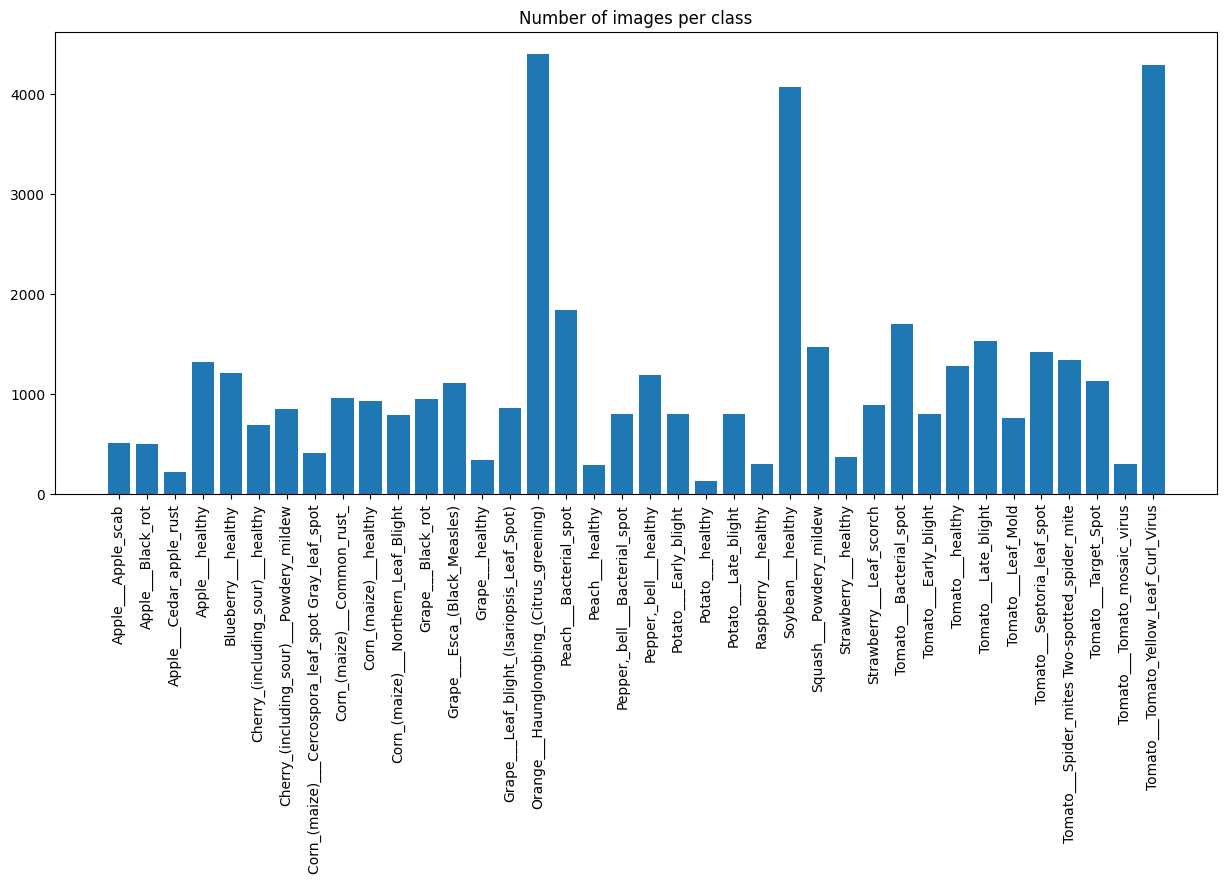

In [ ]:
class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(15, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title('Number of images per class')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.
Training samples: 43444
Validation samples: 10861
Number of classes: 38


In [ ]:
def create_transfer_learning_model():
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False  
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    return model

model = create_transfer_learning_model()
model.summary()

C:\Users\PRIYANSHU MATHUR\AppData\Local\Temp\ipykernel_19360\2873388505.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,623,718 (10.01 MB)

 Trainable params: 365,734 (1.40 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_plant_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [ ]:
train_steps = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

d:\Data Science\plant_diseases\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5504 - loss: 1.6578 - precision: 0.8309 - recall: 0.4052

678/678 ━━━━━━━━━━━━━━━━━━━━ 497s 728ms/step - accuracy: 0.6776 - loss: 1.1140 - precision: 0.8531 - recall: 0.5638 - val_accuracy: 0.8611 - val_loss: 0.4343 - val_precision: 0.9226 - val_recall: 0.8012 - learning_rate: 0.0010
Epoch 2/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 4:00 355ms/step - accuracy: 0.7969 - loss: 0.5855 - precision: 0.8846 - recall: 0.7188

d:\Data Science\plant_diseases\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


678/678 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.7969 - loss: 0.5855 - precision: 0.8846 - recall: 0.7188 - val_accuracy: 0.8616 - val_loss: 0.4326 - val_precision: 0.9208 - val_recall: 0.8011 - learning_rate: 0.0010
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7954 - loss: 0.6510 - precision: 0.8728 - recall: 0.7294

678/678 ━━━━━━━━━━━━━━━━━━━━ 385s 569ms/step - accuracy: 0.8052 - loss: 0.6242 - precision: 0.8775 - recall: 0.7428 - val_accuracy: 0.8790 - val_loss: 0.3736 - val_precision: 0.9172 - val_recall: 0.8438 - learning_rate: 0.0010
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 62s 92ms/step - accuracy: 0.8594 - loss: 0.3618 - precision: 0.9643 - recall: 0.8438 - val_accuracy: 0.8774 - val_loss: 0.3774 - val_precision: 0.9157 - val_recall: 0.8425 - learning_rate: 0.0010
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8258 - loss: 0.5438 - precision: 0.8858 - recall: 0.7775

678/678 ━━━━━━━━━━━━━━━━━━━━ 437s 644ms/step - accuracy: 0.8282 - loss: 0.5402 - precision: 0.8883 - recall: 0.7805 - val_accuracy: 0.9003 - val_loss: 0.3147 - val_precision: 0.9319 - val_recall: 0.8698 - learning_rate: 0.0010
Epoch 6/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 6:03 537ms/step - accuracy: 0.8438 - loss: 0.5524 - precision: 0.9074 - recall: 0.7656

678/678 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - accuracy: 0.8438 - loss: 0.5524 - precision: 0.9074 - recall: 0.7656 - val_accuracy: 0.9021 - val_loss: 0.3120 - val_precision: 0.9316 - val_recall: 0.8695 - learning_rate: 0.0010
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 524s 774ms/step - accuracy: 0.8434 - loss: 0.4920 - precision: 0.8990 - recall: 0.8012 - val_accuracy: 0.9016 - val_loss: 0.3125 - val_precision: 0.9289 - val_recall: 0.8746 - learning_rate: 0.0010
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.8438 - loss: 0.4689 - precision: 0.9074 - recall: 0.7656 - val_accuracy: 0.9011 - val_loss: 0.3106 - val_precision: 0.9288 - val_recall: 0.8741 - learning_rate: 0.0010
Epoch 9/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8496 - loss: 0.4679 - precision: 0.8994 - recall: 0.8123

678/678 ━━━━━━━━━━━━━━━━━━━━ 578s 853ms/step - accuracy: 0.8515 - loss: 0.4654 - precision: 0.9013 - recall: 0.8130 - val_accuracy: 0.9103 - val_loss: 0.2788 - val_precision: 0.9364 - val_recall: 0.8871 - learning_rate: 0.0010
Epoch 10/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.8906 - loss: 0.4227 - precision: 0.9032 - recall: 0.8750 - val_accuracy: 0.9098 - val_loss: 0.2784 - val_precision: 0.9359 - val_recall: 0.8865 - learning_rate: 0.0010
Epoch 11/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 605s 892ms/step - accuracy: 0.8588 - loss: 0.4451 - precision: 0.9043 - recall: 0.8210 - val_accuracy: 0.9091 - val_loss: 0.2792 - val_precision: 0.9361 - val_recall: 0.8842 - learning_rate: 0.0010
Epoch 12/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 65s 96ms/step - accuracy: 0.8438 - loss: 0.3419 - precision: 0.8966 - recall: 0.8125 - val_accuracy: 0.9091 - val_loss: 0.2788 - val_precision: 0.9361 - val_recall: 0.8843 - learning_rate: 0.0010
Epoch 13/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 595s 878ms/step - 

678/678 ━━━━━━━━━━━━━━━━━━━━ 546s 806ms/step - accuracy: 0.8868 - loss: 0.3542 - precision: 0.9234 - recall: 0.8561 - val_accuracy: 0.9227 - val_loss: 0.2447 - val_precision: 0.9419 - val_recall: 0.9026 - learning_rate: 2.0000e-04
Epoch 16/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.9062 - loss: 0.3422 - precision: 0.9474 - recall: 0.8438 - val_accuracy: 0.9224 - val_loss: 0.2440 - val_precision: 0.9418 - val_recall: 0.9024 - learning_rate: 2.0000e-04
Epoch 17/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1984s 3s/step - accuracy: 0.8923 - loss: 0.3377 - precision: 0.9275 - recall: 0.8636 - val_accuracy: 0.9222 - val_loss: 0.2422 - val_precision: 0.9416 - val_recall: 0.9026 - learning_rate: 2.0000e-04
Epoch 18/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.8906 - loss: 0.4537 - precision: 0.9483 - recall: 0.8594 - val_accuracy: 0.9222 - val_loss: 0.2416 - val_precision: 0.9418 - val_recall: 0.9032 - learning_rate: 2.0000e-04
Epoch 19/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 27

678/678 ━━━━━━━━━━━━━━━━━━━━ 215s 317ms/step - accuracy: 0.8963 - loss: 0.3228 - precision: 0.9289 - recall: 0.8685 - val_accuracy: 0.9283 - val_loss: 0.2258 - val_precision: 0.9454 - val_recall: 0.9081 - learning_rate: 2.0000e-04
Epoch 20/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - accuracy: 0.9062 - loss: 0.3171 - precision: 0.9180 - recall: 0.8750 - val_accuracy: 0.9281 - val_loss: 0.2257 - val_precision: 0.9461 - val_recall: 0.9088 - learning_rate: 2.0000e-04


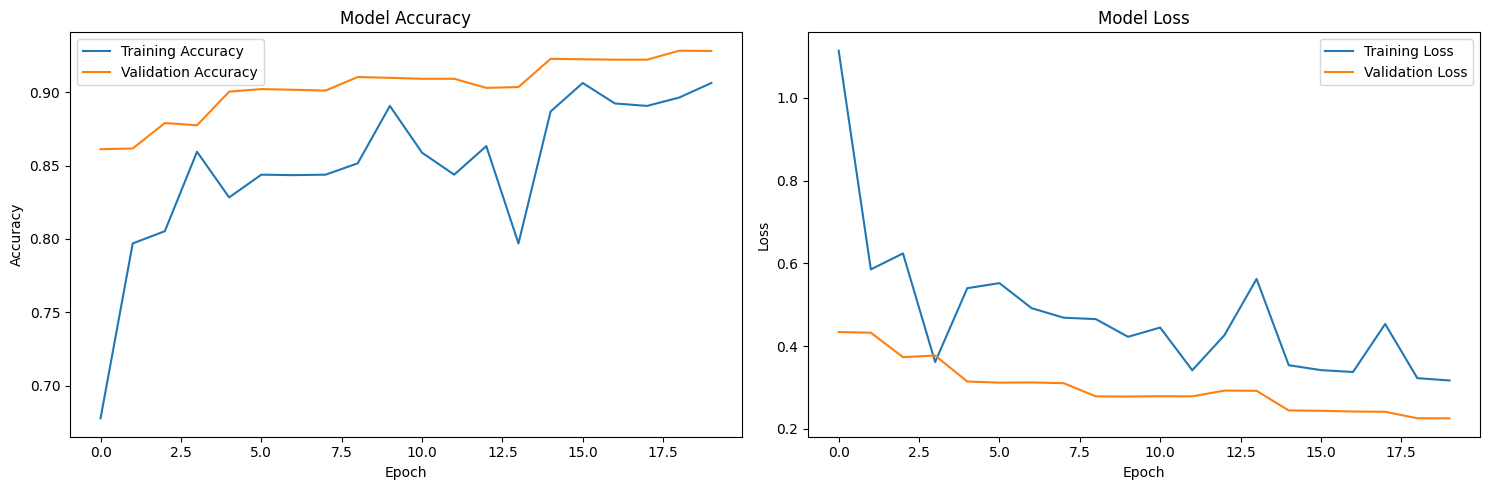

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.9282 - loss: 0.2252 - precision: 0.9461 - recall: 0.9089
Validation Accuracy: 0.9282
Validation Precision: 0.9461
Validation Recall: 0.9089
170/170 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.71      0.82       126
                                 Apple___Black_rot       0.95      0.99      0.97       125
                          Apple___Cedar_apple_rust       0.91      0.96      0.94        55
                                   Apple___healthy       0.91      0.95      0.93       329
                               Blueberry___healthy       0.95      0.95      0.95       300
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.98       210
                 Cherry_(including_sour)___healthy       0.96      0.99      0.98       170
Corn_(maize)___Cercos

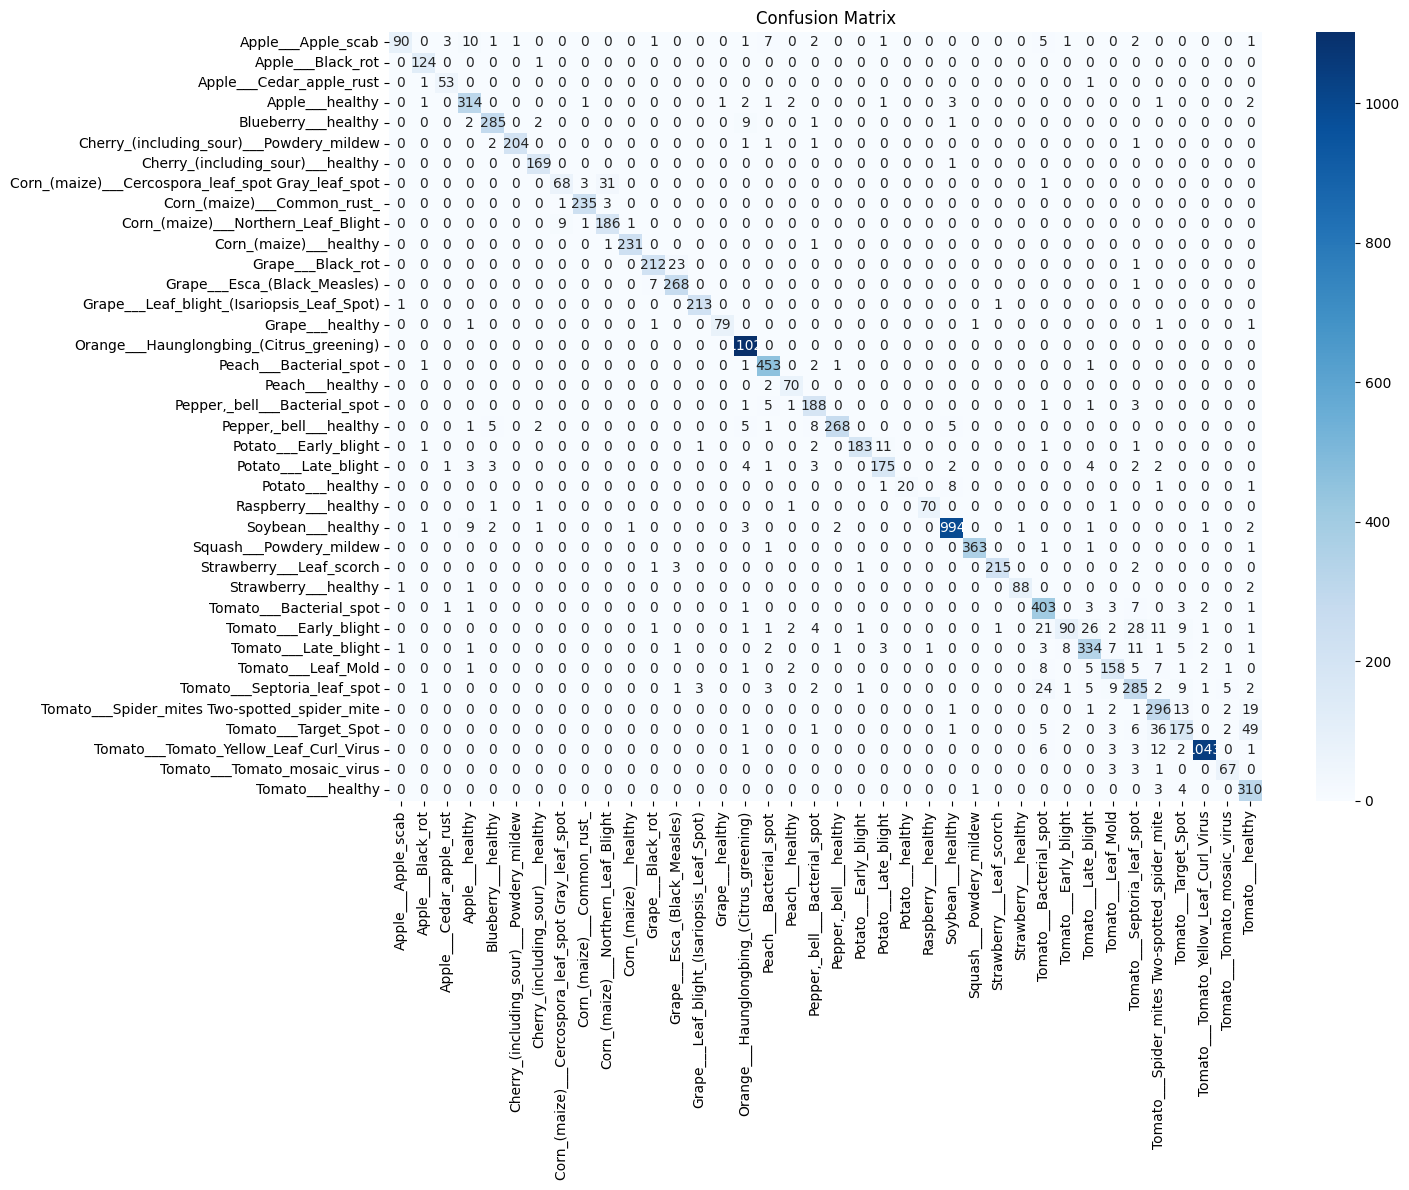

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on validation set
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Predictions for confusion matrix
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
class_labels = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
model.save('plant_disease_detection_model.h5')

import json
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)

print("Model and labels saved successfully!")

Model and labels saved successfully!
